## Environment Setup

In [1]:
!wget https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/code_files/requirements.txt

--2024-08-10 12:44:02--  https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/code_files/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      24  --.-KB/s    in 0s      

2024-08-10 12:44:02 (515 KB/s) - ‘requirements.txt’ saved [24/24]



In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=d7912e8fc3567aa40df4f0a6d848d97dba9b503414cb065d6dfeef0defb4a567
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Data Ingestion

In [1]:
import pandas as pd

class DataLoader:
    def __init__(self, url):
        self.url = url
        self.dataframe = None

    def load_data(self):
        """Load data from the URL into a Pandas DataFrame."""
        self.dataframe = pd.read_csv(self.url)
        return self.dataframe

In [2]:
dataset_url = 'https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/data_files/dataset.csv'
data_loader = DataLoader(dataset_url)
df_raw = data_loader.load_data()

In [3]:
df_raw.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


## Data Pre-processing

In [4]:
import numpy as np
class DataPreprocessor:
    @staticmethod
    def preprocess(dataframe):
        """Preprocess the DataFrame by stripping single quotes from string values."""
        return dataframe.map(lambda x: x.strip("'") if isinstance(x, str) else x)

    @staticmethod
    def rename_columns(dataframe):
        """Rename columns of the DataFrame according to specified mappings."""
        renamed_columns = {
            'step': 'timeStep',
            'customer': 'customerId',
            'age': 'customerAge',
            'gender': 'customerGender',
            'zipcodeOri': 'originZipCode',
            'merchant': 'merchantName',
            'zipMerchant': 'merchantZipCode',
            'category': 'merchantCategory',
            'amount': 'amount',
            'fraud': 'isFraud'
        }
        return dataframe.rename(columns=renamed_columns)

    @staticmethod
    def preprocess_gender(dataframe):
        """
        Preprocess the 'customerGender' column by standardizing values and handling unknowns.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame with the 'customerGender' column.

        Returns:
        pd.DataFrame: The DataFrame with the preprocessed 'customerGender' column.
        """
        dataframe['customerGender'] = dataframe['customerGender'].replace({'E': np.nan, 'U': np.nan})
        return dataframe

    @staticmethod
    def encode_gender(dataframe):
        """
        Encode the 'customerGender' column using one-hot encoding.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame with the 'customerGender' column.

        Returns:
        pd.DataFrame: The DataFrame with the one-hot encoded 'customerGender' column.
        """
        return pd.get_dummies(dataframe, columns=['customerGender'], prefix='Gender', dummy_na=True)

    @staticmethod
    def encode_merchant_category(dataframe):
        """
        Encode the 'merchantCategory' column using one-hot encoding.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame with the 'merchantCategory' column.

        Returns:
        pd.DataFrame: The DataFrame with the one-hot encoded 'merchantCategory' column.
        """
        return pd.get_dummies(dataframe, columns=['merchantCategory'], prefix='Category')

    @staticmethod
    def convert_to_category_codes(df, column_name):
        """
        Convert a categorical column in the DataFrame to category codes.

        Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to convert.

        Returns:
        pd.DataFrame: The DataFrame with the categorical column converted to category codes.
        """
        df[column_name] = df[column_name].astype('category').cat.codes
        return df

    @staticmethod
    def filter_records_with_unidentified_data(df, column_name):
        """
        Filters out rows where 'customerAge' is 'U'.

        Parameters:
        df (pd.DataFrame): The DataFrame to be filtered.

        Returns:
        pd.DataFrame: A DataFrame with rows where 'customerAge' is not 'U'.
        """
        filtered_df = df[df[column_name] != 'U']

        return filtered_df



In [5]:
data_preprocessor = DataPreprocessor()
df_processed = data_preprocessor.preprocess(df_raw)
df_processed = data_preprocessor.rename_columns(df_processed)
df_processed = data_preprocessor.preprocess_gender(df_processed)
df_processed = data_preprocessor.filter_records_with_unidentified_data(df_processed, 'customerAge')
#Encoded dataset
df_encoded = data_preprocessor.encode_gender(df_processed)
df_encoded = data_preprocessor.encode_merchant_category(df_processed)

In [6]:
df_processed.head(5)

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


In [ ]:
df_encoded.head(5)

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,amount,isFraud,Category_es_barsandrestaurants,...,Category_es_home,Category_es_hotelservices,Category_es_hyper,Category_es_leisure,Category_es_otherservices,Category_es_sportsandtoys,Category_es_tech,Category_es_transportation,Category_es_travel,Category_es_wellnessandbeauty
0,0,C1093826151,4,M,28007,M348934600,28007,4.55,0,False,...,False,False,False,False,False,False,False,True,False,False
1,0,C352968107,2,M,28007,M348934600,28007,39.68,0,False,...,False,False,False,False,False,False,False,True,False,False
2,0,C2054744914,4,F,28007,M1823072687,28007,26.89,0,False,...,False,False,False,False,False,False,False,True,False,False
3,0,C1760612790,3,M,28007,M348934600,28007,17.25,0,False,...,False,False,False,False,False,False,False,True,False,False
4,0,C757503768,5,M,28007,M348934600,28007,35.72,0,False,...,False,False,False,False,False,False,False,True,False,False


### Exploratory Data Analysis (EDA)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import missingno as msno

class EDA:
    def __init__(self, df):
        self.df = df

    def plot_imbalance(self, target_variable):
        """Plot the class imbalance for fraud variable."""
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        counts = self.df[target_variable].value_counts()

        plt.figure(figsize=(6, 4))
        counts.plot(kind='bar', color=['blue', 'red'])
        plt.title(f'Imbalance of {target_variable}')
        plt.xlabel(f'{target_variable} (1) vs Not {target_variable} (0)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.show()

    def plot_categorical_distribution(self, df, column):
        """
        Plot categorical distribution for a given column.

        Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        column (str): The column name to plot.
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 6))
        sns.countplot(x=column, data=df)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

    def plot_missing_values_bar(self, dataframe):
        """
        Plot missing values in the given DataFrame using a bar chart.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame to visualize for missing values.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        msno.bar(dataframe)
        plt.title('Non-Missing Values Bar Chart')
        plt.xlabel('Columns')
        plt.ylabel('Count of Non-Missing Values')
        plt.show()

    def plot_customer_age_and_gender_distribution(self, dataframe, column):
        """
        Plot the distribution of customer age and gender using a histogram with KDE.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the customer age data.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 4))
        sns.histplot(dataframe[column], bins=10, kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Frequency')
        plt.show()

    def plot_amount_distribution(sef, dataframe):
        """
        Plot a scatter plot to see the distribution of the 'amount' column,
        marking fraud transactions in red (isFraud = 1).

        Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data to plot.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))

        # Scatter plot for non-fraudulent transactions (isFraud = 0)
        plt.scatter(dataframe[dataframe['isFraud'] == 0]['timeStep'],
                    dataframe[dataframe['isFraud'] == 0]['amount'],
                    alpha=0.5, c='blue', label='Non-Fraudulent')

        # Scatter plot for fraudulent transactions (isFraud = 1)
        plt.scatter(dataframe[dataframe['isFraud'] == 1]['timeStep'],
                    dataframe[dataframe['isFraud'] == 1]['amount'],
                    alpha=0.5, c='red', label='Fraudulent')

        # Plot styling
        plt.title('Distribution of Transaction Amounts Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Transaction Amount')
        plt.legend()

        plt.show()

    def plot_amount_boxplot(self,dataframe):
        """
        Plot a detailed and customized box plot to see the distribution of the 'amount' column.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data to plot.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        # Creating the box plot
        plt.figure(figsize=(12, 8))
        box_plot = sns.boxplot(
            y=dataframe['amount'],
            color='skyblue',
            flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'}
        )

        # Customizing the plot
        plt.title('Box Plot of Transaction Amounts', fontsize=16)
        plt.ylabel('Transaction Amount', fontsize=14)
        plt.xlabel('Transactions', fontsize=14)

        # Adding grid lines for better readability
        plt.grid(True, linestyle='--', linewidth=0.5)

        # Annotating the plot with more details
        plt.annotate(
            'Outliers',
            xy=(0, dataframe['amount'].max()),
            xytext=(0, dataframe['amount'].max() + 10),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12
        )

        # Adding mean and median lines
        mean_value = dataframe['amount'].mean()
        median_value = dataframe['amount'].median()

        plt.axhline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
        plt.axhline(median_value, color='blue', linestyle='-', linewidth=1.5, label=f'Median: {median_value:.2f}')

        plt.legend()

        # Showing the plot
        plt.show()

    def plot_fraud_percentage_by_age(self, df, age_column='customerAge'):
        """
        Creates a stacked bar plot to show the percentage of fraud and non-fraud transactions by customer age.

        Parameters:
        df (pd.DataFrame): DataFrame containing the transaction data.
        age_column (str): Column name representing customer age. Default is 'customerAge'.
        """

        # Calculate the percentage of fraud and not fraud transactions by the specified age column
        age_fraud_summary = df.groupby([age_column, 'isFraud']).size().unstack(fill_value=0)
        age_fraud_summary_percentage = age_fraud_summary.div(age_fraud_summary.sum(axis=1), axis=0) * 100

        # Create the stacked bar plot
        fig, ax = plt.subplots(figsize=(12, 8))
        age_fraud_summary_percentage.plot(kind='bar', stacked=True, ax=ax, color=['blue', 'red'])

        # Set labels and title
        ax.set_xlabel('Customer Age')
        ax.set_ylabel('Percentage of Transactions')
        ax.set_title('Percentage of Fraud and Not Fraud Transactions by Customer Age')
        ax.legend(title='Transaction Type', labels=['Not Fraud', 'Fraud'])

        # Show the plot
        plt.show()


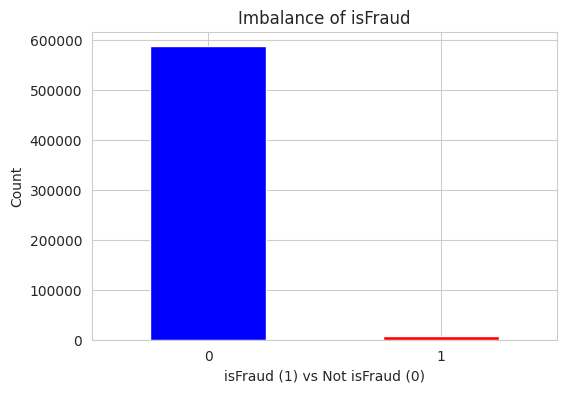

In [32]:
# plot imabalnce of target variable
eda = EDA(df_processed)
eda.plot_imbalance('isFraud')

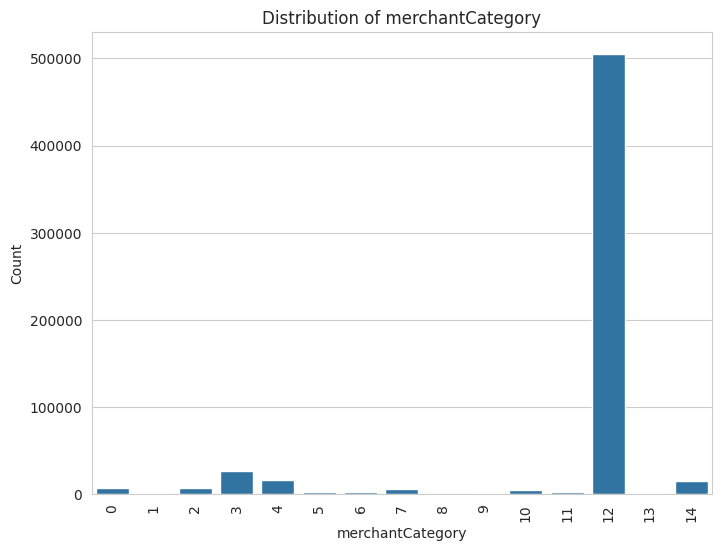

In [17]:
#Plot categorical distribution for merchantCategory column
eda.plot_categorical_distribution(df_processed, 'merchantCategory')

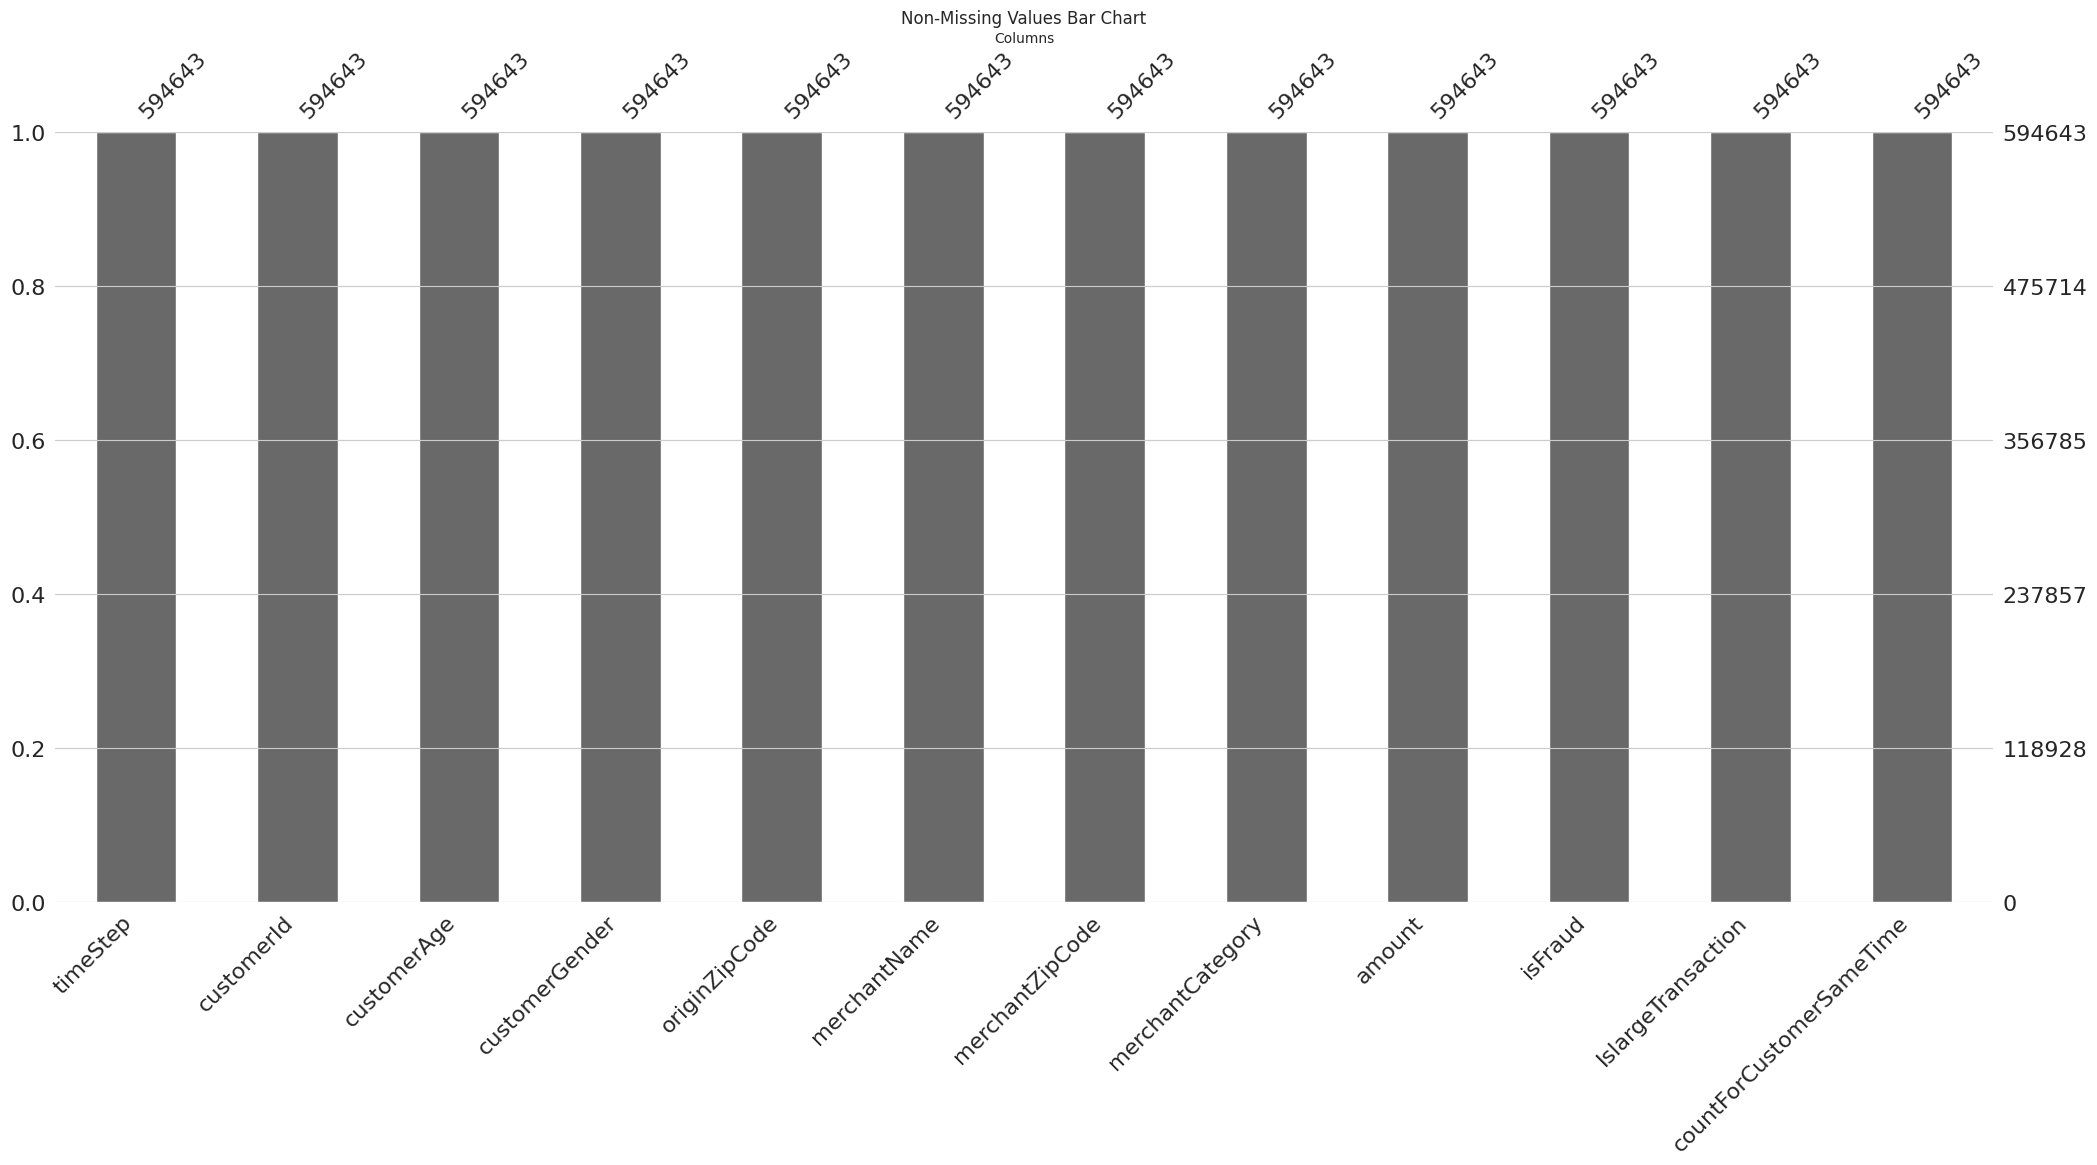

In [18]:
# Plot non-missing values in the given DataFrame using a bar chart
eda.plot_missing_values_bar(df_processed)

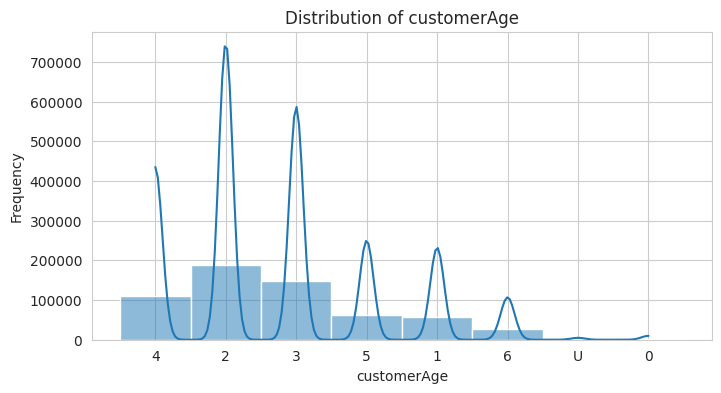

In [19]:
#Plot the distribution of customer age
eda.plot_customer_age_and_gender_distribution(df_processed, 'customerAge')

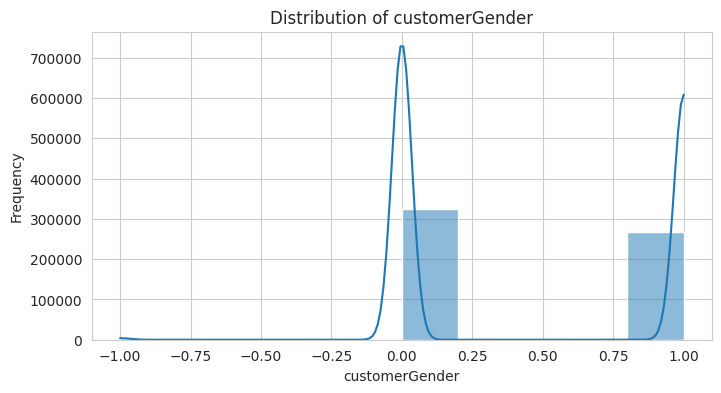

In [20]:
#Plot the distribution of customer gender
eda.plot_customer_age_and_gender_distribution(df_processed, 'customerGender')

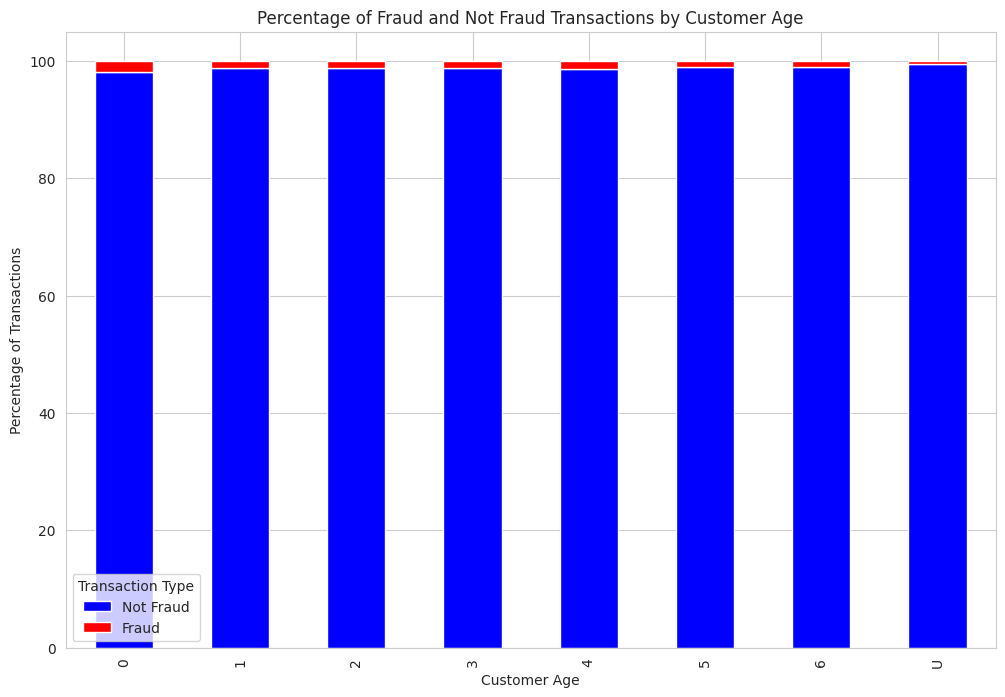

In [33]:
eda.plot_fraud_percentage_by_age(df_processed, age_column='customerAge')

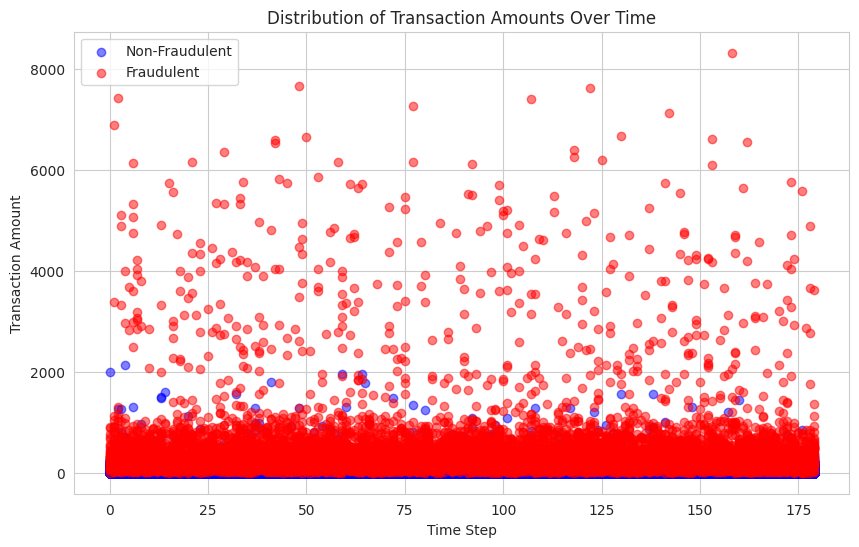

In [ ]:
eda.plot_amount_distribution(df_processed)

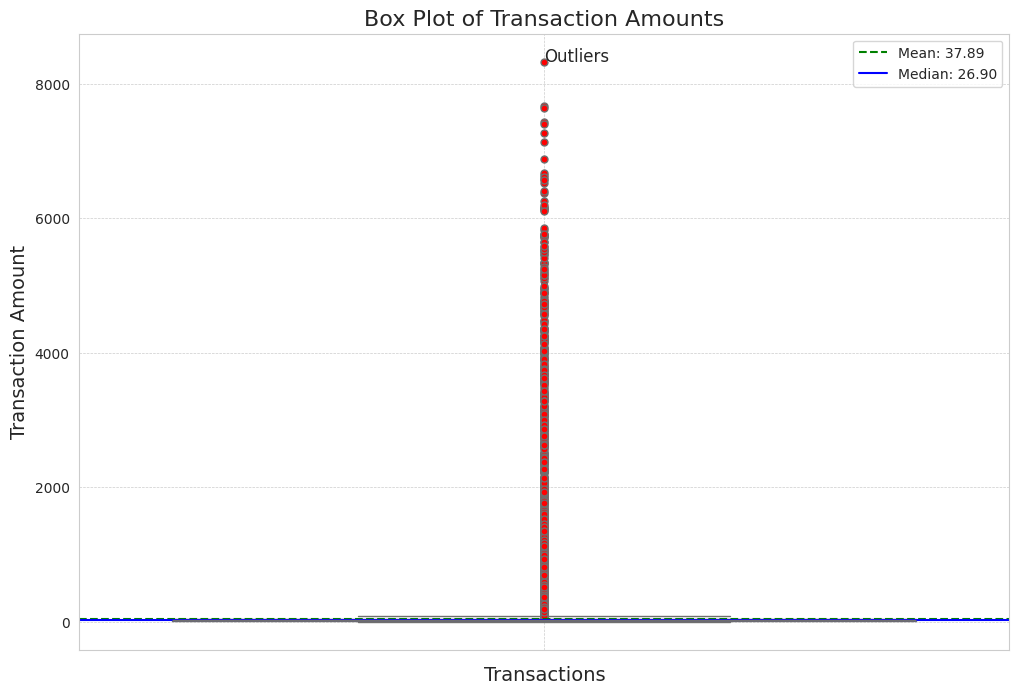

In [ ]:
eda.plot_amount_boxplot(df_processed)

EDA for fraudlent transactions

In [ ]:
df_fraud_trx = df_processed[df_processed['isFraud'] == 1]

In [ ]:
edaFraud = EDA(df_fraud_trx)

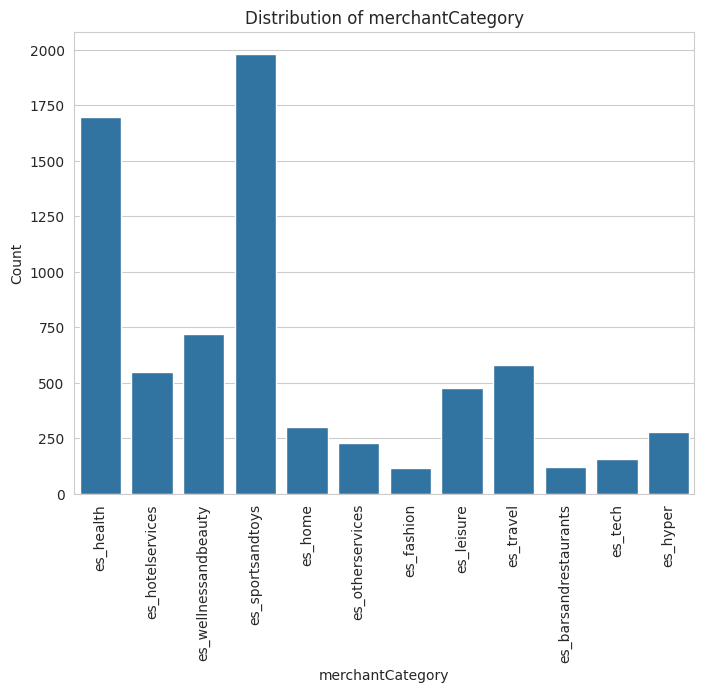

In [ ]:
#Plot categorical distribution for merchantCategory column
edaFraud.plot_categorical_distribution(df_fraud_trx, 'merchantCategory')

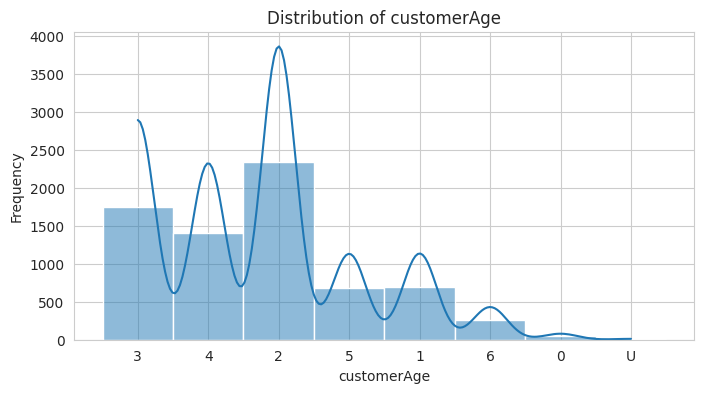

In [ ]:
#Plot the distribution of customer age
edaFraud.plot_customer_age_and_gender_distribution(df_fraud_trx, 'customerAge')

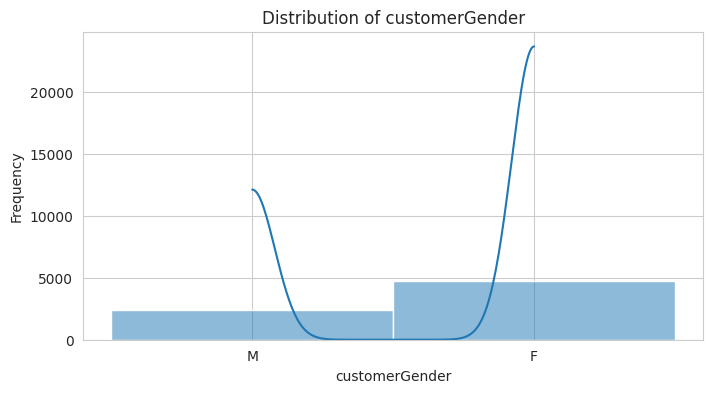

In [ ]:
#Plot the distribution of customer gender
edaFraud.plot_customer_age_and_gender_distribution(df_fraud_trx, 'customerGender')

### More pre-processing to handle categorical values

In [8]:
# Convert categorical column to category codes
df_processed = data_preprocessor.convert_to_category_codes(df_processed, 'merchantCategory')
df_processed = data_preprocessor.convert_to_category_codes(df_processed, 'customerGender')

In [9]:
df_processed

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud
0,0,C1093826151,4,1,28007,M348934600,28007,12,4.55,0
1,0,C352968107,2,1,28007,M348934600,28007,12,39.68,0
2,0,C2054744914,4,0,28007,M1823072687,28007,12,26.89,0
3,0,C1760612790,3,1,28007,M348934600,28007,12,17.25,0
4,0,C757503768,5,1,28007,M348934600,28007,12,35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,0,28007,M1823072687,28007,12,20.53,0
594639,179,C650108285,4,0,28007,M1823072687,28007,12,50.73,0
594640,179,C123623130,2,0,28007,M349281107,28007,2,22.44,0
594641,179,C1499363341,5,1,28007,M1823072687,28007,12,14.46,0


## Feature Engineering

In [10]:
def process_transactions(df):
    """
    Adds 'IslargeTransaction' and 'countForCustomerSameTime' columns to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the transaction data with 'amount', 'timeStep', and 'customerId' columns.

    Returns:
    pd.DataFrame: DataFrame with the new columns added.
    """
    # Add 'IslargeTransaction' column based on the condition
    df['IslargeTransaction'] = df['amount'].apply(lambda x: 1 if x >= 5000 else 0)

    # Calculate the count of transactions for each customer at each time step
    df['countForCustomerSameTime'] = df.groupby(['timeStep', 'customerId'])['customerId'].transform('count')

    return df

def add_avg_transaction_amount(df, customer_id_col='customerId', amount_col='amount'):
    """
    Adds a new column to the DataFrame that contains the average transaction amount
    for each customerId.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the transaction data.
    customer_id_col (str): The column name representing customer IDs. Default is 'customerId'.
    amount_col (str): The column name representing transaction amounts. Default is 'amount'.

    Returns:
    pd.DataFrame: The DataFrame with an added column 'avgTransactionAmount'.
    """
    # Calculate the average transaction amount for each customerId
    avg_transaction_amount = df.groupby(customer_id_col)[amount_col].mean()

    # Map the average transaction amount back to the original DataFrame
    df['avgTransactionAmount'] = df[customer_id_col].map(avg_transaction_amount)

    return df

In [11]:
# Apply the function to process the DataFrame
df_processed = process_transactions(df_processed)

In [12]:
df_processed = add_avg_transaction_amount(df_processed)

In [13]:
df_processed.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,C1093826151,4,1,28007,M348934600,28007,12,4.55,0,0,1,28.240719
1,0,C352968107,2,1,28007,M348934600,28007,12,39.68,0,0,1,32.661361
2,0,C2054744914,4,0,28007,M1823072687,28007,12,26.89,0,0,1,41.443692
3,0,C1760612790,3,1,28007,M348934600,28007,12,17.25,0,0,1,30.338772
4,0,C757503768,5,1,28007,M348934600,28007,12,35.72,0,0,1,31.696759


# Baseline models for Fraud Detection

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

def train_random_forest(df, categorical_columns, target_column='isFraud', test_size=0.25, n_estimators=10, random_state=42):
    """
    Trains a Random Forest classifier and evaluates its performance.

    Parameters:
    df (pd.DataFrame): DataFrame containing the features and target variable.
    categorical_columns (list): List of column names that need to be encoded.
    target_column (str): The name of the target column in the DataFrame. Default is 'isFraud'.
    test_size (float): Proportion of the data to include in the test split. Default is 0.25.
    random_state (int): Seed for the random number generator. Default is 42.

    Returns:
    None
    """
    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # Train the model
    rf_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_clf.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


**Experiment 1: RandomForest without oversampling**

In [ ]:
# Columns to encode
categorical_columns = ['customerId', 'merchantName', 'customerAge']

# Call the function to train the Random Forest classifier
train_random_forest(df_processed, categorical_columns)

Accuracy: 0.9960446922864773
Confusion Matrix:
 [[146760    151]
 [   437   1313]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    146911
           1       0.90      0.75      0.82      1750

    accuracy                           1.00    148661
   macro avg       0.95      0.87      0.91    148661
weighted avg       1.00      1.00      1.00    148661



### Addressing Dataset Imbalance

### SMOTE - (Synthetic Minority Over-sampling Technique)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

class SmoteOverSampling:
    def __init__(self, dataframe, target_column, test_size=0.2, random_state=42):
        """
        Initialize the SmoteOverSampling with the given parameters.

        :param dataframe: DataFrame containing the dataset
        :param target_column: Column name of the target variable
        :param test_size: Proportion of the dataset to include in the test split
        :param random_state: Random state for reproducibility
        """
        self.dataframe = dataframe
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state

    def encode_categorical(self):
        """
        Encode categorical features using integer encoding.

        This method converts categorical features into integer labels
        that can be provided to machine learning algorithms.
        """
        label_encoders = {}
        for column in self.dataframe.select_dtypes(include=['object']).columns:
            label_encoders[column] = LabelEncoder()
            self.dataframe[column] = label_encoders[column].fit_transform(self.dataframe[column])
        self.label_encoders = label_encoders

    def apply_smote(self):
        """
        Apply SMOTE to balance the dataset.

        This method separates the features and the target variable,
        applies SMOTE to generate synthetic samples for the minority class,
        and stores the resampled features and target in instance variables.
        """
        X = self.dataframe.drop(self.target_column, axis=1)
        y = self.dataframe[self.target_column]

        smote = SMOTE(random_state=self.random_state)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        self.X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
        self.y_resampled = pd.Series(y_resampled, name=self.target_column)

        # Create DataFrame for the original and synthetic samples
        self.df_processed_os = self.X_resampled.copy()
        self.df_processed_os[self.target_column] = self.y_resampled

    def scale_features(self):
        """
        Scale the features using StandardScaler.

        This method standardizes the features by removing the mean and
        scaling to unit variance, and stores the scaled features.
        """
        scaler = StandardScaler()
        self.X_resampled_scaled = scaler.fit_transform(self.X_resampled)

    def split_data(self):
        """
        Split the data into training and testing sets.

        This method splits the resampled and scaled data into training
        and testing sets and returns them.

        :return: X_train, X_test, y_train, y_test
        """
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_resampled_scaled, self.y_resampled,
            test_size=self.test_size, random_state=self.random_state
        )
        return X_train, X_test, y_train, y_test

In [ ]:
# Initialize the preprocessor
preprocessor = SmoteOverSampling(df_processed, target_column='isFraud')

# Encode categorical features
preprocessor.encode_categorical()

# Apply SMOTE to balance the dataset
preprocessor.apply_smote()

# The new DataFrame with original and synthetic samples
df_processed_os = preprocessor.df_processed_os

# Optionally, you can now scale features and split the data if needed
preprocessor.scale_features()
X_train, X_test, y_train, y_test = preprocessor.split_data()

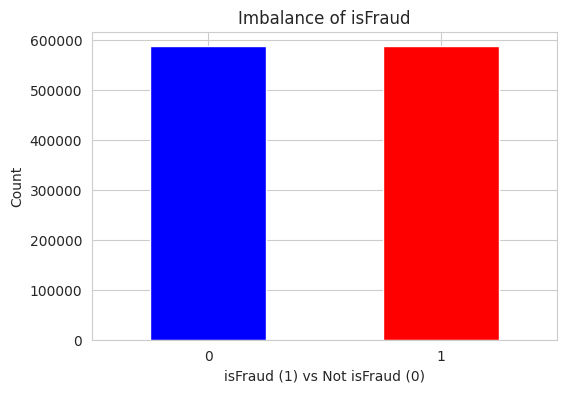

In [ ]:
# plot imabalnce of target variable after SMOTE
eda = EDA(df_processed_os)
eda.plot_imbalance('isFraud')

**Experiment 2: RandomForest with oversampled data (SMOTE)**

In [ ]:
# Columns to encode
categorical_columns = ['customerId', 'merchantName', 'customerAge']

# Call the function to train the Random Forest classifier
train_random_forest(df_processed_os, categorical_columns)

Accuracy: 0.9956932065013857
Confusion Matrix:
 [[145891    951]
 [   314 146566]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    146842
           1       0.99      1.00      1.00    146880

    accuracy                           1.00    293722
   macro avg       1.00      1.00      1.00    293722
weighted avg       1.00      1.00      1.00    293722



# Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

def create_nn_model(input_dim):
    """
    Creates a neural network model.

    Parameters:
    input_dim (int): Number of features in the input data.

    Returns:
    model (Sequential): Compiled neural network model.
    """
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate_nn(df, categorical_columns, target_column='isFraud', test_size=0.25, random_state=42):
    """
    Trains a neural network on the data and evaluates its performance.

    Parameters:
    df (pd.DataFrame): DataFrame containing the features and target variable.
    categorical_columns (list): List of column names that need to be encoded.
    target_column (str): The name of the target column in the DataFrame.
    test_size (float): Proportion of the data to include in the test split.
    random_state (int): Seed for the random number generator.

    Returns:
    None
    """
    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create the neural network model
    model = create_nn_model(input_dim=X_train.shape[1])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

**Experiment 3: Neural Network without oversampling**

In [ ]:
# Call the function to train and evaluate the neural network
train_and_evaluate_nn(df_processed, categorical_columns)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11150/11150 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9871 - loss: 0.1927 - val_accuracy: 0.9925 - val_loss: 0.0344
Epoch 2/10
11150/11150 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.9928 - loss: 0.0309 - val_accuracy: 0.9923 - val_loss: 0.0305
Epoch 3/10
11150/11150 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9931 - loss: 0.0280 - val_accuracy: 0.9933 - val_loss: 0.0277
Epoch 4/10
11150/11150 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9934 - loss: 0.0269 - val_accuracy: 0.9933 - val_loss: 0.0281
Epoch 5/10
11150/11150 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9935 - loss: 0.0257 - val_accuracy: 0.9935 - val_loss: 0.0272
Epoch 6/10
11150/11150 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9935 - loss: 0.0261 - val_accuracy: 0.9936 - val_loss: 0.0246
Epoch 7/10
11150/11150 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9935 - loss: 0.0250 - val_accuracy: 0.9933 - val_loss: 0.0256
Epoch 8/10
11150/11150 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 

**Experiment 4: Neural Network with Oversampling (SMOTE)**

In [ ]:
# Call the function to train and evaluate the neural network
train_and_evaluate_nn(df_processed_os, categorical_columns)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.8927 - loss: 0.9870 - val_accuracy: 0.9299 - val_loss: 0.1793
Epoch 2/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.9405 - loss: 0.1543 - val_accuracy: 0.9583 - val_loss: 0.1183
Epoch 3/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.9577 - loss: 0.1199 - val_accuracy: 0.9645 - val_loss: 0.1034
Epoch 4/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.9610 - loss: 0.1108 - val_accuracy: 0.9603 - val_loss: 0.1103
Epoch 5/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.9623 - loss: 0.1059 - val_accuracy: 0.9658 - val_loss: 0.1062
Epoch 6/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.9640 - loss: 0.1025 - val_accuracy: 0.9627 - val_loss: 0.1125
Epoch 7/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 0.9646 - loss: 0.1003 - val_accuracy: 0.9677 - val_loss: 0.0928
Epoch 8/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 

# XGBOOST

In [17]:
df_processed.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,C1093826151,4,1,28007,M348934600,28007,12,4.55,0,0,1,28.240719
1,0,C352968107,2,1,28007,M348934600,28007,12,39.68,0,0,1,32.661361
2,0,C2054744914,4,0,28007,M1823072687,28007,12,26.89,0,0,1,41.443692
3,0,C1760612790,3,1,28007,M348934600,28007,12,17.25,0,0,1,30.338772
4,0,C757503768,5,1,28007,M348934600,28007,12,35.72,0,0,1,31.696759


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb


def preprocess_data(df):
    """
    Preprocess the data by splitting into features and target, and performing train-test split.
    :param df: DataFrame
    :return: X_train, X_test, y_train, y_test
    """
    X = df.drop(columns=['isFraud'])
    y = df['isFraud']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    return X_train, X_test, y_train, y_test


def build_pipeline():
    """
    Build and return a machine learning pipeline with preprocessing and XGBoost classifier.
    :return: Pipeline
    """
    numeric_features = ['amount', 'customerAge', 'countForCustomerSameTime', 'timeStep', 'avgTransactionAmount']
    categorical_features = ['customerGender', 'merchantName', 'merchantCategory']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb_model)
    ])

    return pipeline


def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    """
    Train and evaluate the model.
    :param pipeline: Pipeline
    :param X_train: Training features
    :param X_test: Testing features
    :param y_train: Training target
    :param y_test: Testing target
    """
    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(y_test, y_pred_test))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_test))


def main():
    """
    Main function to run the data processing, model training, and evaluation.
    :param file_path: str, path to the CSV file
    """
    X_train, X_test, y_train, y_test = preprocess_data(df_processed)
    pipeline = build_pipeline()
    evaluate_model(pipeline, X_train, X_test, y_train, y_test)

**Experiment 5: XGBoost (Extreme Gradient Boosting)**

In [22]:
if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:06:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.9975
Test Accuracy: 0.9967
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175882
           1       0.90      0.82      0.86      2158

    accuracy                           1.00    178040
   macro avg       0.95      0.91      0.93    178040
weighted avg       1.00      1.00      1.00    178040

Confusion Matrix:
[[175690    192]
 [   397   1761]]


# Retrieval Augmented Generation